# SVM x Decision Trees x Random Forest Performance Comparison

## Dataset Description

In [3]:
import pandas as pd

data = pd.read_csv('data/onlinefoods.csv')
data.head()

,Age,Gender,Marital Status,Occupation,Monthly Income,Educational Qualifications,Family size,Pin code,Output,Feedback
0,20,Female,Single,Student,No Income,Post Graduate,4,560001,Yes,Positive
1,24,Female,Single,Student,Below Rs.10000,Graduate,3,560009,Yes,Positive
2,22,Male,Single,Student,Below Rs.10000,Post Graduate,3,560017,Yes,Negative
3,22,Female,Single,Student,No Income,Graduate,6,560019,Yes,Positive
4,22,Male,Single,Student,Below Rs.10000,Post Graduate,4,560010,Yes,Positive


In [4]:
data.describe()

,Age,Family size,Pin code
count,388.000000,388.000000,388.000000
mean,24.628866,3.280928,560040.113402
std,2.975593,1.351025,31.399609
min,18.000000,1.000000,560001.000000
25%,23.000000,2.000000,560010.750000
50%,24.000000,3.000000,560033.500000
75%,26.000000,4.000000,560068.000000
max,33.000000,6.000000,560109.000000


## Outlier Detection
IQR outlier detection for continuous columns


Outliers detected using IQR method:
Series([], Name: Age, dtype: int64)


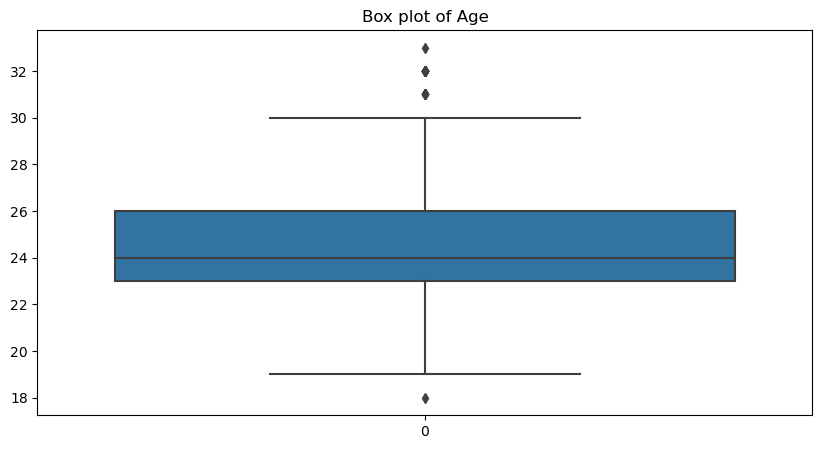

In [5]:
# Outlier Detection
import numpy as np
from scipy.stats import zscore

# Select the column you want to analyze
column_name = 'Age'  # replace with the actual column name
selected_data = data[column_name]

# IQR method
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.05)
    Q3 = data.quantile(0.95)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers

# Detect outliers using both methods
outliers_iqr = detect_outliers_iqr(selected_data)

# Print outliers
print("\nOutliers detected using IQR method:")
print(outliers_iqr)

# Visualize outliers using a box plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.boxplot(selected_data)
plt.title(f'Box plot of {column_name}')
plt.show()


## Binning and Label Encoding
Data is binned to be used for feature selection, since Chi Square Test requires the columns to be categorical

In [6]:
# Manually bin columns
binned_age = pd.cut(data["Age"],
            bins=[17, 22, 26, 29, 34],
            labels=['1', '2', '3', '4'])

binned_pinCode =  pd.cut(data["Pin code"],
            bins=[560000, 560025, 560050, 560075, 560100, 560125],
            labels=['1', '2', '3', '4', '5'])


# Label encode all columns except manually binned columns
from library.bin import label_encode_all
data = label_encode_all(data, exclude_columns=['Age', 'Pin code'])


# Replace the original columns
data['Age'] = binned_age
data['Pin code'] = binned_pinCode

# Show new data
data.head()


,Age,Gender,Marital Status,Occupation,Monthly Income,Educational Qualifications,Family size,Pin code,Output,Feedback
0,1,0,2,3,4,2,3,1,1,1
1,2,0,2,3,2,0,2,1,1,1
2,1,1,2,3,2,2,2,1,1,0
3,1,0,2,3,4,0,5,1,1,1
4,1,1,2,3,2,2,3,1,1,1


## Feature Selection